<a href="https://colab.research.google.com/github/nirjalalala/learn_ml/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CONCRETE DATA**

Data from - https://www.kaggle.com/datasets/elikplim/concrete-compressive-strength-data-set/data

###**Objective**:
---
<br> To perform EDA and fit a regression model that predicts concrete-compression-strength based on various other features.

---

###IMPORTING THE LIBRARIES

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error


###LOADING THE DATASET

In [2]:
#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/concrete_data.csv')

#Printing first 5 rows ensures that the dataset has been loaded properly.
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


##EXPLORATORY DATA ANALYSIS

In [3]:
#Checking datatypes and null values in the columns of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB




*   There are 9 colums and 1030 total rows.
*   There are no missing values.
*   All columns are numeric.



In [4]:
#Statistical measures of all column
df.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [5]:
df.isnull().sum().sum()

np.int64(0)

No missing values.

In [6]:
#Correlation among the variables
corr = df.corr()

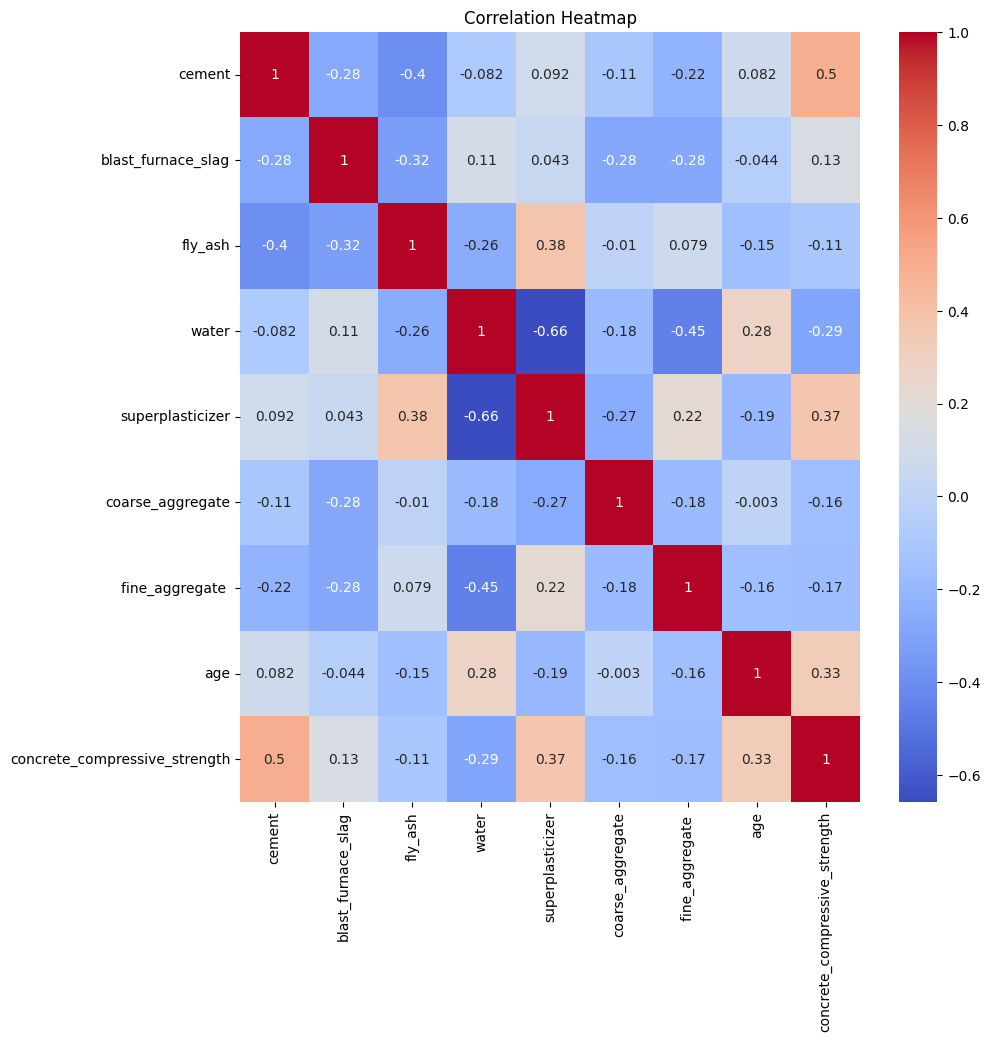

In [7]:
#Visualizing the correlation using a heat map

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True,cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Features like water, fine_aggregate and superplasticizer have high correlation with each other.

We can also find the correlation of our target variable with the predicting variables.

In [8]:
#Correlation of 'concrete_compressive_strength' with remaining variables

corr['concrete_compressive_strength'].sort_values(ascending=False)

,concrete_compressive_strength
concrete_compressive_strength,1.000000
cement,0.497832
superplasticizer,0.366079
age,0.328873
blast_furnace_slag,0.134829
fly_ash,-0.105755
coarse_aggregate,-0.164935
fine_aggregate,-0.167241
water,-0.289633


We can see that, 'concrete_compressive_strength' has:
*  moderate positive correlation with features like 'cement' , 'superplasticizer', 'age' and 'blast_furnace_slag'.
* weak negative correlation with features like 'water', 'fine_aggregate', 'coarse_aggregate' and 'fly_ash'.
* Highest correlation is with 'cement' while the lowest correlation is with 'fly_ash'.

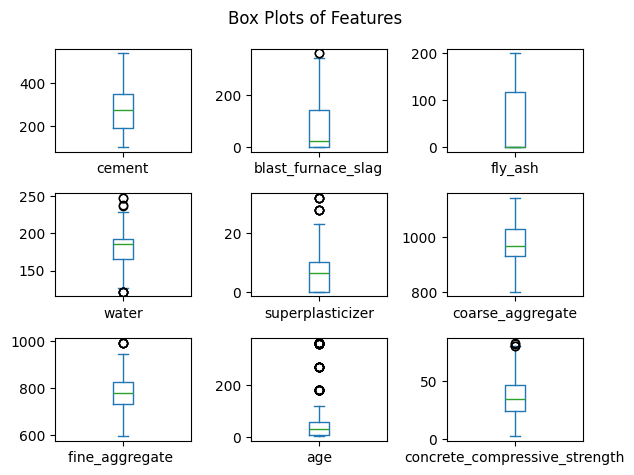

In [9]:
#boxplots for each columns for outlier detection

df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.suptitle("Box Plots of Features")
plt.tight_layout()
plt.show()

####Impute Outliers with mean values

In [10]:
df_copy = df.copy()

for column in df_copy.columns:
  #IQR method for handling outliers
  Q1 = df_copy[column].quantile(0.25)
  Q3 = df_copy[column].quantile(0.75)
  IQR = Q3 - Q1
  #defining lower and upper bounds
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  #replacing outliers with mean values
  df_copy.loc[df_copy[column] < lower_bound, column] = df_copy[column].mean().astype(int)
  df_copy.loc[df_copy[column] > upper_bound, column] = df_copy[column].mean().astype(int)


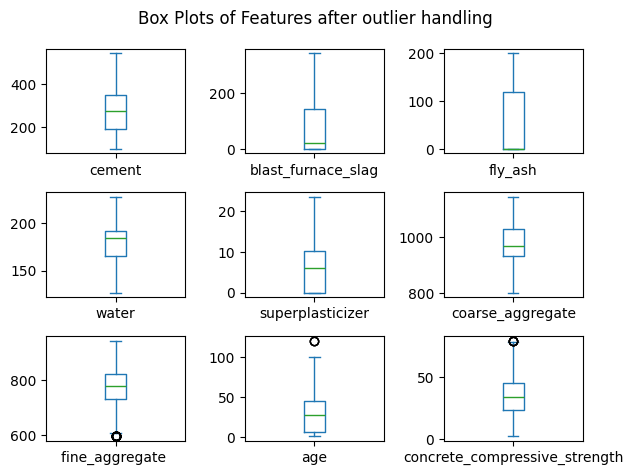

In [11]:
#boxplots for each column after outlier handling

df_copy.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.suptitle("Box Plots of Features after outlier handling")
plt.tight_layout()
plt.show()

#### <-

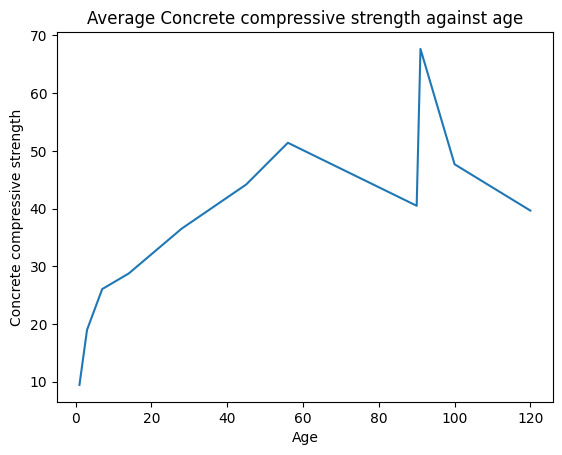

In [12]:
# To use a line plot, group by age and calculate the mean
age_strength_mean = df_copy.groupby('age')['concrete_compressive_strength'].mean().reset_index()

sns.lineplot(x='age', y='concrete_compressive_strength', data=age_strength_mean)
plt.title("Average Concrete compressive strength against age")
plt.xlabel("Age")
plt.ylabel("Concrete compressive strength")
plt.show()

This shows how the average concrete compressive strength changes as age increases. The maximum average strength is seen at age 100 days.

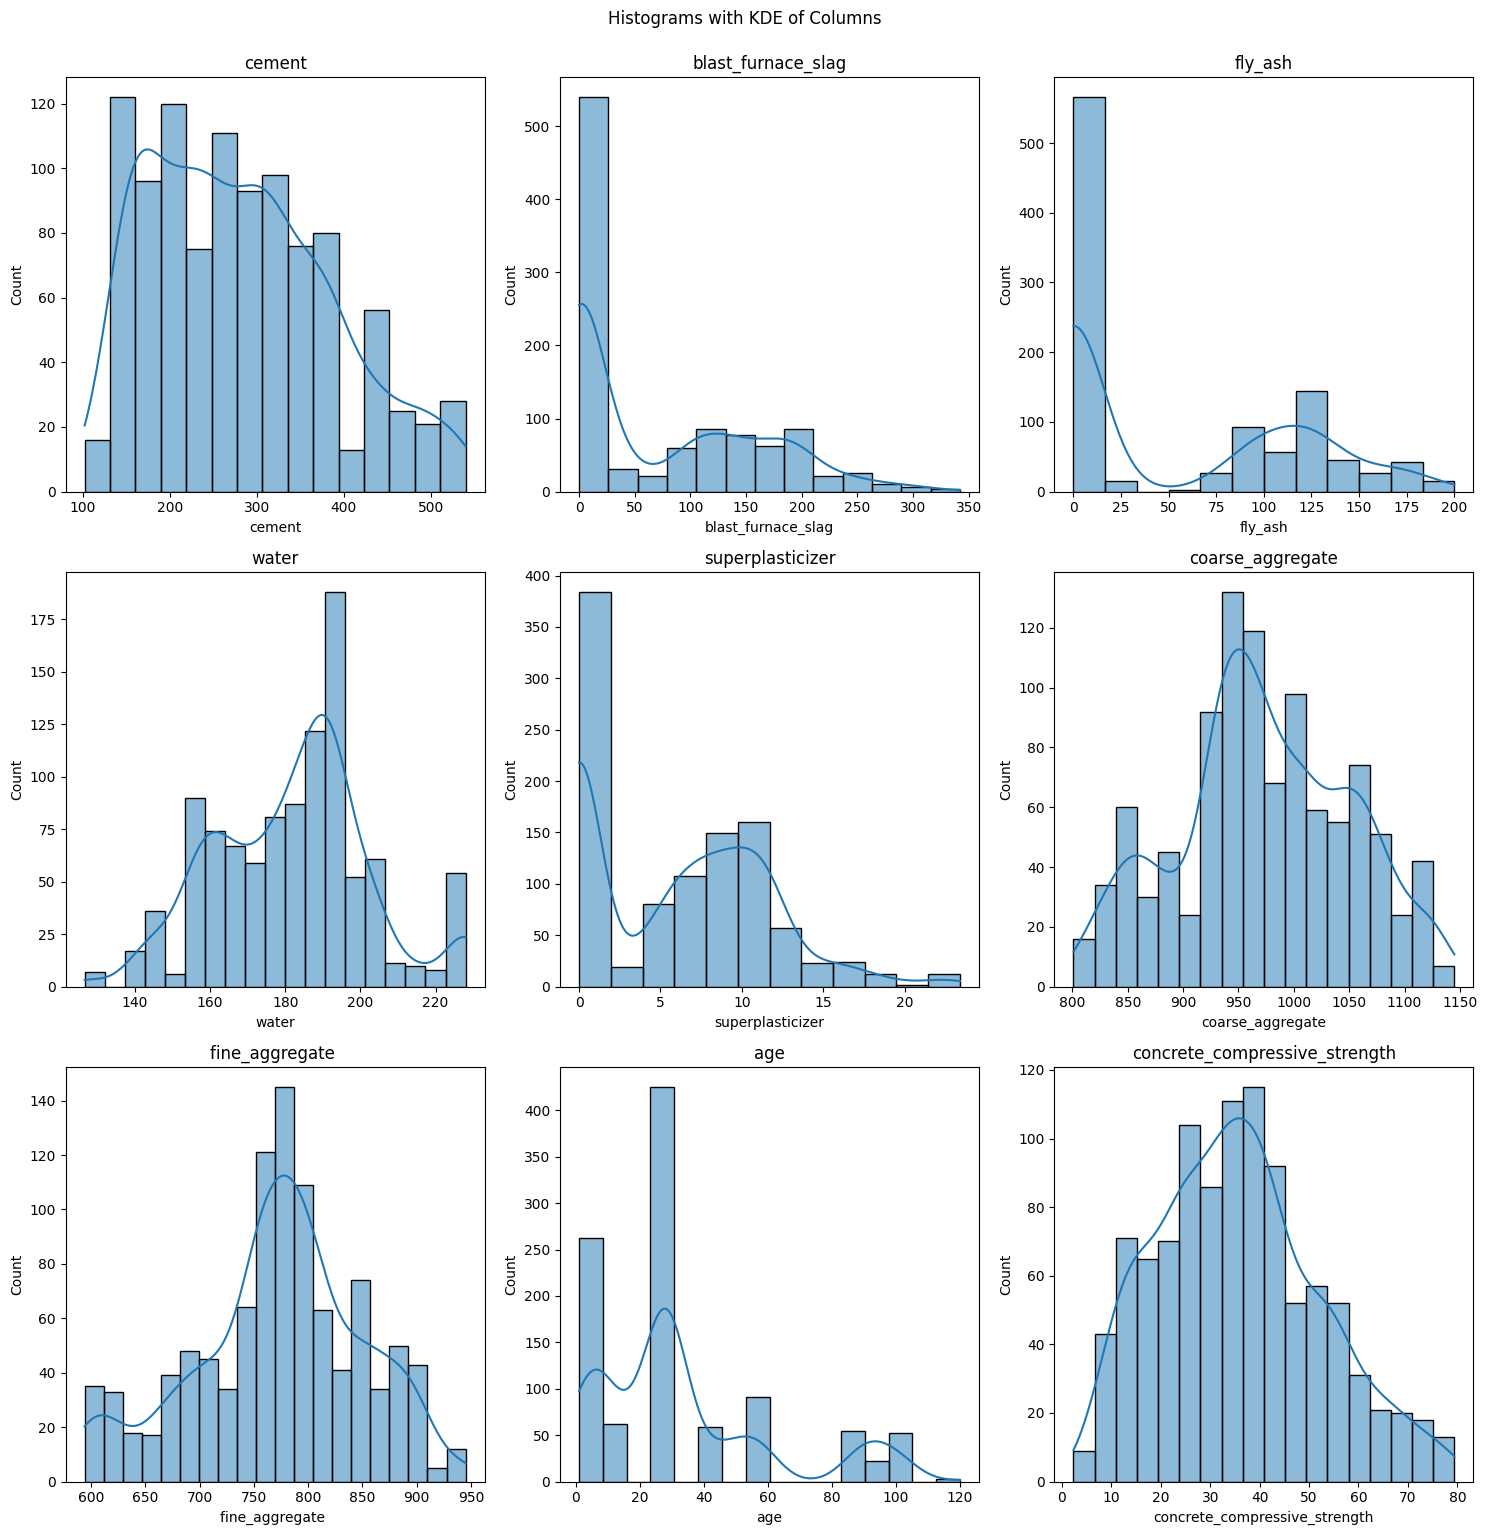

In [13]:
#Creating a distplot for all numerical features

# Create a figure and a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the columns and the axes
for i, column in enumerate(df.columns):
    # Plot the histogram with KDE using seaborn.histplot
    sns.histplot(data=df_copy, x=column, kde=True, ax=axes[i])
    axes[i].set_title(column)


plt.tight_layout() # Adjust layout to prevent overlapping titles and labels
plt.suptitle( y=1.02, t="Histograms with KDE of Columns")
plt.show()

* None of our features have normal distribution.
* The peak of all distributions can be viewed to identify mode and median values.
* The diagram shows wider spread for features like age, blast_furnance_sage and fly_ash.

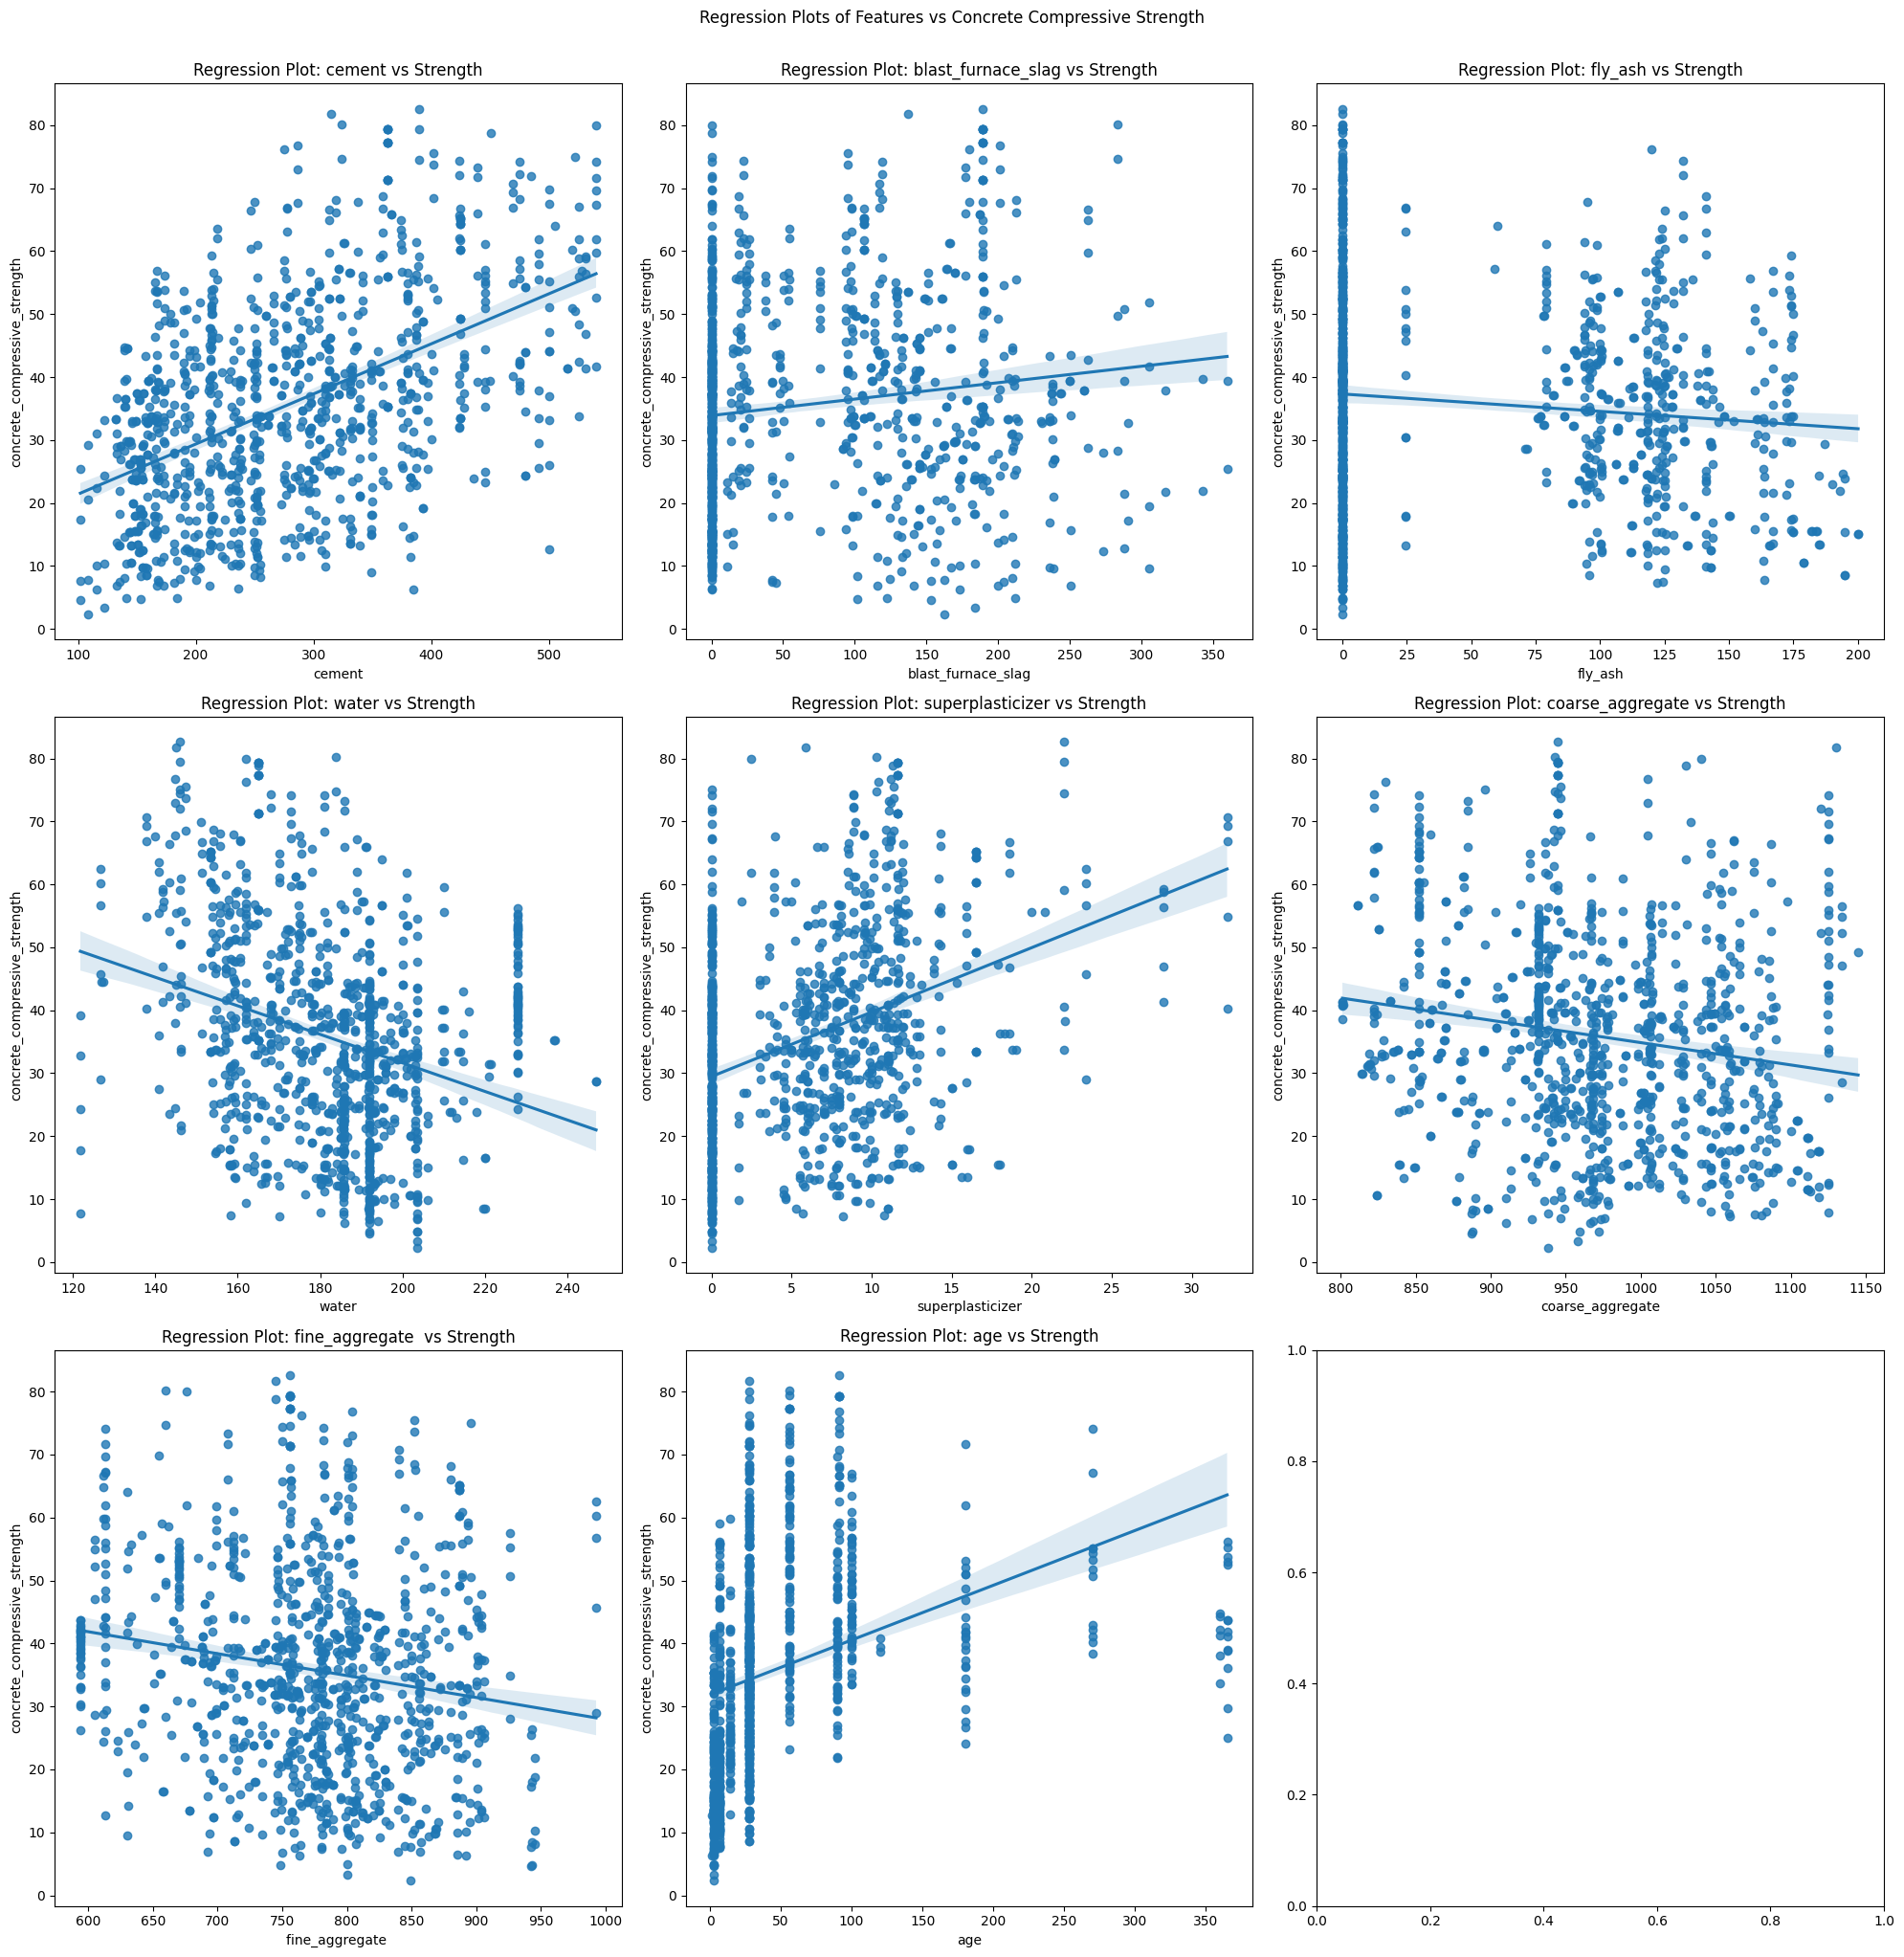

In [14]:
# Creating reg-plots between target variable and each of the other features

# Create a figure and a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the feature columns and the axes
for i, column in enumerate(df.columns[:-1]):
  # Plot the regplot on the current axis
  sns.regplot(x=df[column], y=df['concrete_compressive_strength'], ax=axes[i])
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('concrete_compressive_strength')
  axes[i].set_title(f"Regression Plot: {column} vs Strength")

plt.tight_layout()
plt.suptitle("Regression Plots of Features vs Concrete Compressive Strength", y=1.02)
plt.show()

The regression plots for each feature against 'concrete_compressive_strength' visually demonstrate the relationship between each individual feature and the target variable.
* For example, the regplot for 'cement' shows a positive linear trend, indicating that higher cement content generally leads to higher compressive strength.
* The regplot for 'water', on the other hand, shows a negative linear trend, suggesting that more water tends to decrease compressive strength. <br> These visual insights align with the correlation analysis performed before.

##DATA PREPROCESSING

In [15]:
#Load our X features and y label
X = df_copy.drop('concrete_compressive_strength',axis=1).values
y = df_copy['concrete_compressive_strength'].values

#Split our data as training data and testing data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=17)


In [16]:
#Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

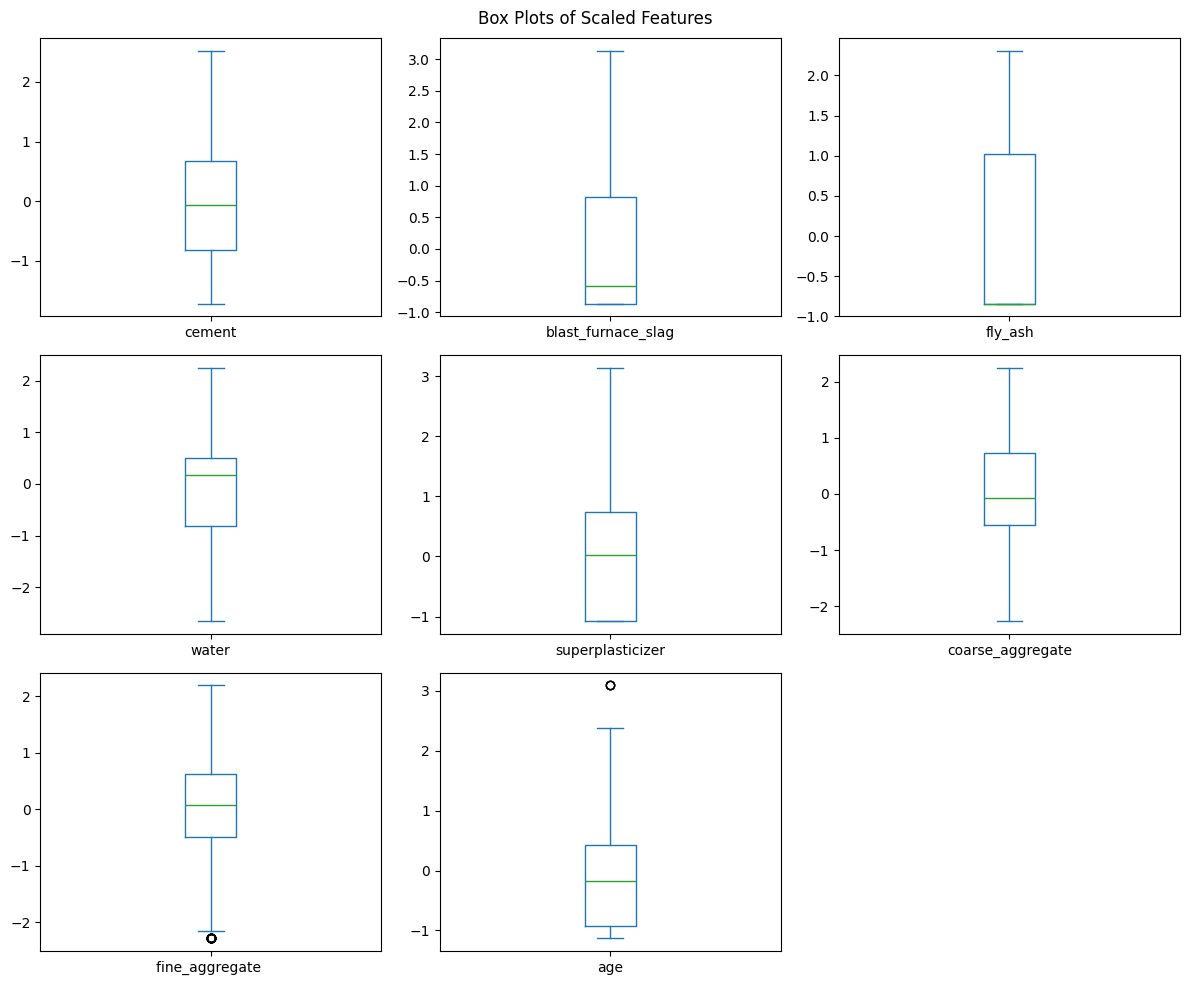

In [18]:
df_scaled = pd.DataFrame(X_train_scaled, columns=df_copy.drop('concrete_compressive_strength', axis=1).columns)

#Box-plot after Scaling
df_scaled.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(12, 10))
plt.suptitle("Box Plots of Scaled Features")
plt.tight_layout()
plt.show()

As we can see, our data is now centered at 0 (mostly).

In [19]:
#Save df_scaled as csv file

df_scaled.to_csv('df_scaled.csv', index=False)

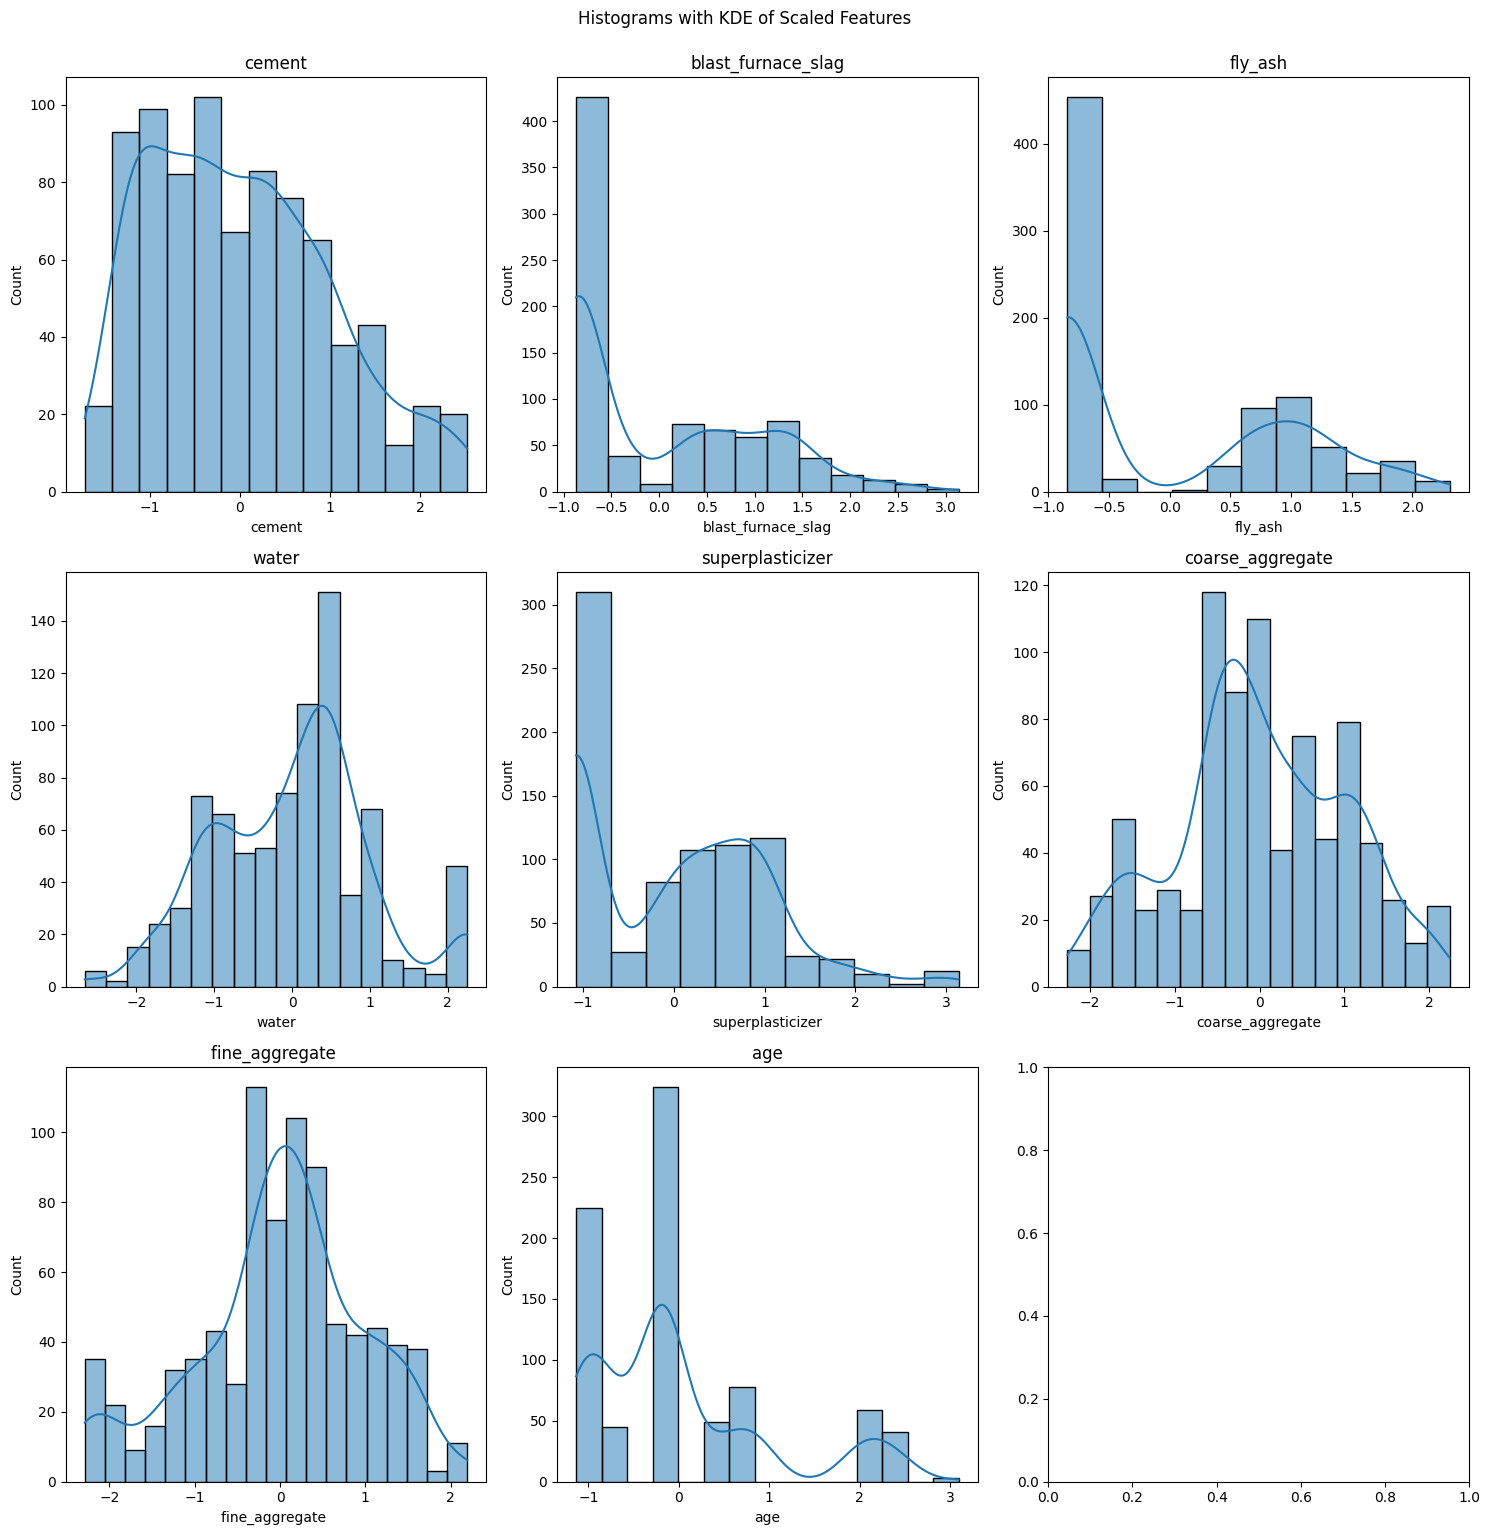

In [20]:
#Creating a distplot for all numerical features

# Create a figure and a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the columns and the axes
for i, column in enumerate(df_scaled.columns):
    # Plot the histogram with KDE using seaborn.histplot
    sns.histplot(data=df_scaled, x=column, kde=True, ax=axes[i])
    axes[i].set_title(column)


plt.tight_layout() # Adjust layout to prevent overlapping titles and labels
plt.suptitle("Histograms with KDE of Scaled Features", y=1.02)
plt.show()

The distribution shape is preserved. But now our data is concerntrated around 0.

##BUILDING THE MODELS

We'll try five different regression models:
* Linear Regression
* Ridge Regression
* Decision Tree Regression
* Random Forest Regression
* Support Vector Regression

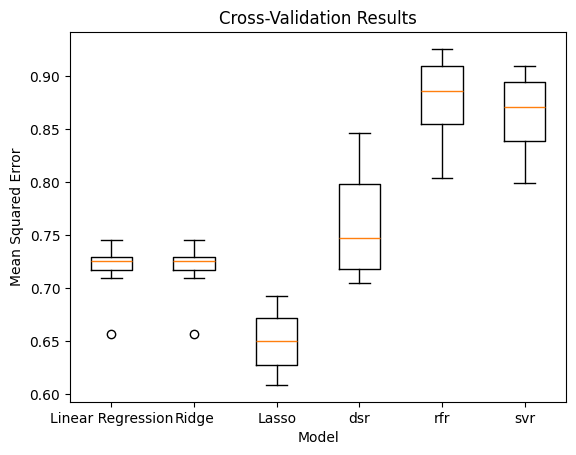

In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=0.1),
    "Lasso": Lasso(alpha=0.1),
    "dsr": DecisionTreeRegressor(max_depth=5,min_samples_split=5),
    "rfr": RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5),
    "svr": SVR()
    }

#Creating a list that will hold cross-validation scores of all models
results = []

#Creating a KFold object
#This performs training and validation for a same model for 7 times
#Every time, the validation data changes.
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# Loop through the models' values
for model in models.values():

  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=kf)

  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, tick_labels=models.keys())
plt.title("Cross-Validation Results")
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.show()

In [22]:
test_mse = {}
for name, model in models.items():

  # Fit the model to the training data
  model.fit(X_train_scaled,y_train_scaled)

  # Make predictions on the test set
  y_pred = model.predict(X_test_scaled)

  # Calculate the test_rmse
  test_mse[name] = mean_squared_error(y_test_scaled, y_pred)
  print(f"{name} Test Set MSE: {test_mse[name]}")

Linear Regression Test Set MSE: 0.22302400639543848
Ridge Test Set MSE: 0.2229898933008417
Lasso Test Set MSE: 0.25620402197384007
dsr Test Set MSE: 0.2352029330027815
rfr Test Set MSE: 0.09170300305923212
svr Test Set MSE: 0.10860426415042786


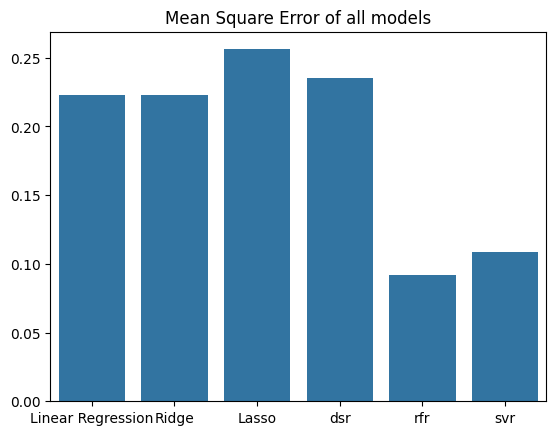

In [23]:
#bar graph to show mse of all models

sns.barplot(x=list(models.keys()), y=test_mse.values())
plt.title("Mean Square Error of all models")
plt.show()

From above two figures, we conclude that the rfr (random forest regresser) model has the least errors and highest cross validation scores.

In [24]:
#Create the model
rfr = RandomForestRegressor(random_state=42)

# Fit to the training data
rfr.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

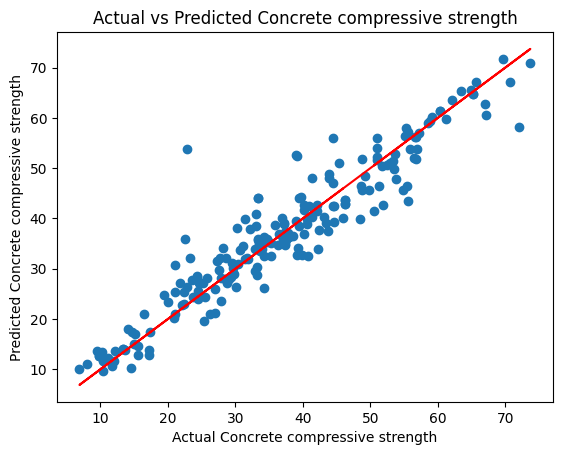

In [25]:
#Make predictions on the test data using the tuned model
y_pred = rfr.predict(X_test)

#Visualize the model prediction using scatter-plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Concrete compressive strength")
plt.ylabel("Predicted Concrete compressive strength")
plt.plot(y_test,y_test, color='red')
plt.title("Actual vs Predicted Concrete compressive strength")
plt.show()

Our model prediction is pretty good as the data points follow a linear pattern.


In [26]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regressor Test Set MSE: {mse}")
print(f"Random Forest Regressor Test Set RMSE: {rmse}")
print(f"Random Forest Regressor Test Set R-squared: {r2}")

Random Forest Regressor Test Set MSE: 23.427178255354757
Random Forest Regressor Test Set RMSE: 4.840163040162465
Random Forest Regressor Test Set R-squared: 0.8998067538125826


##TUNING THE HYPER-PARAMETERS OF SELECTED MODEL

The model we will be tuning is RandomForestRegression model.

In [27]:
from sklearn.model_selection import RandomizedSearchCV


In [28]:

param_grid = {
                  "n_estimators":[50,100,150,200],
                  "max_depth":[None, 10, 20],
                  "min_samples_split":[2,4,6]
            }

rfr_cv = RandomizedSearchCV(rfr, param_distributions=param_grid, cv=kf, n_iter=36, random_state=42) # Added n_iter

In [29]:
# Fit the RandomizedSearchCV object to the scaled training data
rfr_cv.fit(X_train_scaled, y_train_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42)

In [38]:
#Printing the tuned parameters and validation score
print("Tuned paramaters: {}".format(rfr_cv.best_params_))
print("Tuned score: {}".format(rfr_cv.best_score_))

Tuned paramaters: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': None}
Tuned score: 0.8905079452624681


In [39]:
#Get the tuned model
regression_model = rfr_cv.best_estimator_

In [40]:
regression_model

RandomForestRegressor(n_estimators=150, random_state=42)

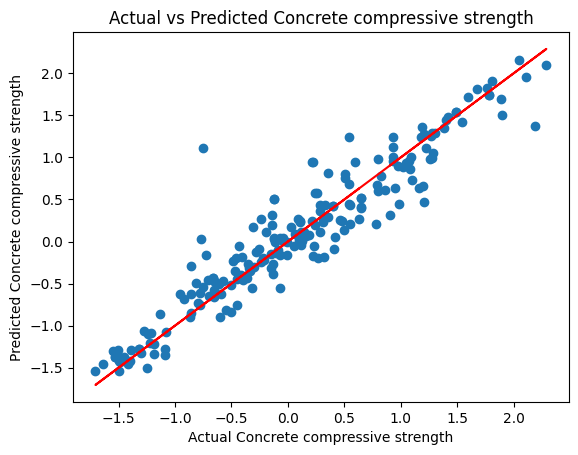

In [43]:
#Make predictions on the test data using the tuned model
y_pred_tuned = regression_model.predict(X_test_scaled)

#Visualize the model prediction using scatter-plot
plt.scatter(y_test_scaled, y_pred_tuned)
plt.xlabel("Actual Concrete compressive strength")
plt.ylabel("Predicted Concrete compressive strength")
plt.plot(y_test_scaled,y_test_scaled, color='red')
plt.title("Actual vs Predicted Concrete compressive strength")
plt.show()

In [45]:
mse_tuned = mean_squared_error(y_test_scaled, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned) # Calculate RMSE
r2_tuned = r2_score(y_test_scaled, y_pred_tuned)

print(f"Tuned Random Forest Regressor Test Set MSE: {mse_tuned}")
print(f"Tuned Random Forest Regressor Test Set RMSE: {rmse_tuned}")
print(f"Tuned Random Forest Regressor Test Set R-squared: {r2_tuned}")

Tuned Random Forest Regressor Test Set MSE: 0.08386958500218279
Tuned Random Forest Regressor Test Set RMSE: 0.2896024602833733
Tuned Random Forest Regressor Test Set R-squared: 0.8996401894332824


###**SAVING THE MODEL**

In [46]:
import joblib

In [51]:
joblib.dump(regression_model, 'tuned_regression_rfr.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [49]:
joblib.dump(rfr, 'baseline_regression_rfr.pkl')

['baseline_regression_rfr.pkl']

#**Concrete Compressive Strength Prediction - Model Training Summary**
---
**Objective:** To train a regression model to predict concrete compressive strength based on various features.

---

**Data:** The model was trained on the Concrete Compressive Strength dataset.

---

**Methodology:**

---
* **Data Preparation**: The dataset was loaded and explored. Key steps included checking data types, identifying missing values (none found), and examining descriptive statistics and correlations. The data was split into training and testing sets (80/20 split).
* **Feature Scaling**: Features were scaled using StandardScaler to ensure that no single feature dominated the model due to differences in scale.
* **Model Selection**: Several regression models were initially evaluated using cross-validation on the training set: Linear Regression, Ridge Regression, Lasso Regression, Decision Tree Regression, Random Forest Regression, and Support Vector Regression.
* **Model Performance Evaluation (Initial)**: The Mean Squared Error (MSE) and cross-validation scores were used to compare the initial performance of the models. Random Forest Regression showed promising performance based on these initial assessments.
* **Hyperparameter Tuning**: The Random Forest Regressor model, identified as a strong candidate, was selected for hyperparameter tuning using GridSearchCV with 7-fold cross-validation. The parameters tuned included n_estimators, max_depth, and min_samples_split.
* **Tuned Model Evaluation**: The tuned Random Forest Regressor model was evaluated on the independent test set to assess its generalization performance.

---
**Results:**

---
* The GridSearchCV identified the optimal hyperparameters for the Random Forest Regressor within the defined search space.
* The tuned Random Forest Regressor model achieved the following performance metrics on the test set:
1. Mean Squared Error (MSE): 22.640489185206313
2. Root Mean Squared Error (RMSE): 4.758202306040204
3. R-squared (R²):  0.9031712619415254

---
**Conclusion:**

---

The model training and tuning process for predicting concrete compressive strength is complete. A Random Forest Regressor model has been trained and tuned, and its performance on the independent test set has been evaluated. The obtained metrics provide an indication of the model's ability to predict concrete strength on unseen data.

---
**Next Steps:**

---

* Further analysis of model predictions and potential areas for improvement (e.g., feature engineering, exploring other models).
* Deployment of the trained model for making predictions on new concrete data.

---